In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
nickel_data = pd.read_csv("dataWithHeat.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data.head()

,Name,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,954.0,1.0,788.0,8.0,704.0,8,760.0,500,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,1121.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,1232.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,1010.0,4.0,843.0,4.0,760.0,16,0.0,0,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for Yield

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

yield_data = hf.clean_dataframe(nickel_data, "Tensile Strength, Yield")
yield_data.head()

,"Tensile Strength, Yield",Heat treatment 1 Time,Heat treatment 2 Time,Heat treatment 3 Time,Heat treatment 4 Time,Al,B,C,Co,Cr,...,stage_2_Hot,stage_2_No_HT,stage_2_Warm,stage_3_Anneal,stage_3_Hot,stage_3_No_HT,stage_3_Warm,stage_4_Hot,stage_4_No_HT,stage_4_Warm
0,989.0,1.0,8.0,8.0,500.0,1.5,0.005,0.020,9.100000,17.40,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,1074.0,1.0,16.0,0.0,0.0,0.0,0.000,0.050,0.000000,20.00,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,1055.0,0.0,0.0,0.0,0.0,5.0,0.020,0.070,18.530001,12.38,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12,260.0,1.0,4.0,0.0,0.0,0.0,0.000,0.150,20.000000,21.00,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14,1581.0,2.0,8.0,24.0,0.0,2.5,0.030,0.025,14.750000,16.00,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
yield_data = yield_data.drop(columns=["Heat treatment 1 Time", "Heat treatment 2 Time", "Heat treatment 3 Time", "Heat treatment 4 Time"])

In [5]:

yield_train_data = yield_data.sample(frac=0.8, random_state=2212)
yield_test_data = yield_data.drop(yield_train_data.index)

yield_data.head()

,"Tensile Strength, Yield",Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,stage_2_Hot,stage_2_No_HT,stage_2_Warm,stage_3_Anneal,stage_3_Hot,stage_3_No_HT,stage_3_Warm,stage_4_Hot,stage_4_No_HT,stage_4_Warm
0,989.0,1.5,0.005,0.020,9.100000,17.40,0.0,9.7,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,1074.0,0.0,0.000,0.050,0.000000,20.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,1055.0,5.0,0.020,0.070,18.530001,12.38,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12,260.0,0.0,0.000,0.150,20.000000,21.00,0.0,30.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14,1581.0,2.5,0.030,0.025,14.750000,16.00,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
yield_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Yield",833.0,792.066223,303.588623,55.0,604.000,819.000000,1000.000000,1654.000000
Al,833.0,2.232041,1.948483,0.0,0.500,1.500000,3.500000,6.600000
B,833.0,0.010172,0.015895,0.0,0.000,0.006000,0.015000,0.160000
C,833.0,0.057496,0.042776,0.0,0.025,0.050000,0.070000,0.180000
Co,833.0,8.120433,7.902916,0.0,0.000,8.960000,14.750000,35.000000
Cr,833.0,16.063206,4.643062,0.0,14.000,17.230000,19.200001,29.500000
Cu,833.0,0.004802,0.097940,0.0,0.000,0.000000,0.000000,2.000000
Fe,833.0,6.412953,10.817215,0.0,0.000,0.000000,15.000000,45.220001
Hf,833.0,0.095670,0.343272,0.0,0.000,0.000000,0.000000,1.800000
La,833.0,0.000360,0.003781,0.0,0.000,0.000000,0.000000,0.050000


In [7]:
yield_train_features = yield_train_data.copy()
yield_test_features = yield_test_data.copy()

yield_train_labels = yield_train_features.pop("Tensile Strength, Yield")
yield_test_labels = yield_test_features.pop("Tensile Strength, Yield")

In [8]:
yield_normalizer = hf.normalize(yield_train_features)

First example: [[ 0.45  0.    0.   29.    5.5   0.   34.8   0.    0.    0.    0.    0.
   0.    4.8  24.25  0.    0.    0.    0.35  0.    0.85  0.    0.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    1.    0.
   0.    0.    1.    0.    1.    0.  ]]

Normalized: [[-0.92 -0.39 -1.34  2.64 -2.28 -0.05  2.63 -0.28 -0.1  -0.1  -0.39 -1.1
  -0.11  1.58 -3.4  -0.31 -0.05  0.    1.31 -0.4  -0.76 -0.16 -0.48 -0.17
  -0.08 -0.18 -0.49  0.66 -0.49 -0.33 -0.1  -0.5  -0.79 -0.56  2.12 -0.25
  -0.53 -1.02  1.9  -0.25  0.34 -0.22]]


In [9]:
hf.model_builder(kt.HyperParameters(), yield_normalizer)

In [10]:
tuner = kt.RandomSearch(lambda hp : hf.model_builder(hp, norm=yield_normalizer),
                     objective='val_loss',
                     max_trials=100,
                     overwrite=True,
                     directory='model_search',
                     project_name='yield_model')

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [11]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 1
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 30, 'step': 50, 'sampling': None}


In [12]:
tuner.search(yield_train_features, yield_train_labels, epochs=50, validation_split=0.2, callbacks=[es], verbose=2)


Trial 1 Complete [00h 00m 04s]
val_loss: 99.56019592285156

Best val_loss So Far: 99.56019592285156
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in model_search\yield_model
Showing 10 best trials
Trial summary
Hyperparameters:
layer_1_units: 30
Score: 99.56019592285156


In [14]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
best_hps.get_config()['values']

{'layer_1_units': 30}

In [16]:
yield_model = tuner.hypermodel.build(best_hps)

yield_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 42)               85        
 n)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1290      
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,406
Trainable params: 1,321
Non-trainable params: 85
___________________________________________________

In [17]:
history = yield_model.fit(yield_train_features, yield_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=2)

Epoch 1/10000
21/21 - 0s - loss: 99.9545 - val_loss: 99.9476 - 455ms/epoch - 22ms/step
Epoch 2/10000
21/21 - 0s - loss: 99.9199 - val_loss: 99.9379 - 34ms/epoch - 2ms/step
Epoch 3/10000
21/21 - 0s - loss: 99.9166 - val_loss: 99.9281 - 34ms/epoch - 2ms/step
Epoch 4/10000
21/21 - 0s - loss: 99.9057 - val_loss: 99.9184 - 35ms/epoch - 2ms/step
Epoch 5/10000
21/21 - 0s - loss: 99.8961 - val_loss: 99.9088 - 31ms/epoch - 1ms/step
Epoch 6/10000
21/21 - 0s - loss: 99.8958 - val_loss: 99.8992 - 34ms/epoch - 2ms/step
Epoch 7/10000
21/21 - 0s - loss: 99.8746 - val_loss: 99.8896 - 32ms/epoch - 2ms/step
Epoch 8/10000
21/21 - 0s - loss: 99.8855 - val_loss: 99.8802 - 34ms/epoch - 2ms/step
Epoch 9/10000
21/21 - 0s - loss: 99.8717 - val_loss: 99.8706 - 32ms/epoch - 2ms/step
Epoch 10/10000
21/21 - 0s - loss: 99.8545 - val_loss: 99.8612 - 32ms/epoch - 2ms/step
Epoch 11/10000
21/21 - 0s - loss: 99.8361 - val_loss: 99.8517 - 32ms/epoch - 2ms/step
Epoch 12/10000
21/21 - 0s - loss: 99.8352 - val_loss: 99.8423

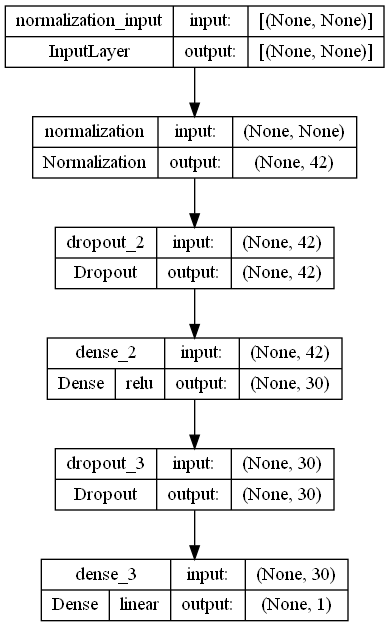

In [18]:
utils.plot_model(yield_model, show_layer_activations=True, show_shapes=True)

In [19]:
yield_model.evaluate(yield_test_features, yield_test_labels, verbose=0)

36.47224426269531

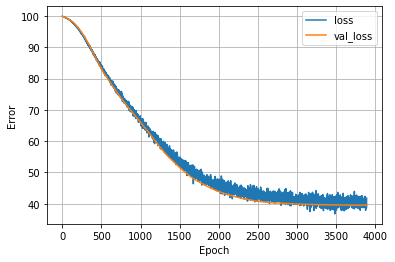

In [20]:
hf.plot_loss(history)

7/7 [==============================] - 0s 667us/step


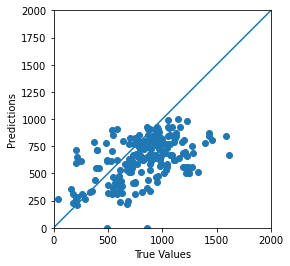

In [21]:
test_predictions = yield_model.predict(yield_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(yield_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)